# Exercise Sheet #2

# Exercise Sheet #2: Battleships (1/2)

### Probabilistic Machine Learning

- **Lecturer**: Prof. Philipp Hennig
- **Term**: SoSe 2020
- **Due Date**: Monday, 04 May 2020, 10am


![battleship rules](https://upload.wikimedia.org/wikipedia/commons/e/e4/Battleships_Paper_Game.svg)

Over the course of two weeks, we will implement an agent that can play the pen-and-paper game _Battleships_. The goal of this exercise sheet is to find exact prior probabilities of getting a hit by enumeration, and to update to a posterior given observations of hits and misses. This week we will understand why we can't construct the agent with this approach.  

Next week we will use Monte Carlo techniques to build an agent that we can play against :). Stay tuned!

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

### **2.1** A priori probability for a hit with one boat

**Tasks**
1. Write a function that takes the length of a boat and that returns the prior probability to observe a hit.
2. Plot the prior for a carrier (length 5).


*Hint:* You can find this probability by enumerating all possible positions of the boat.

In [3]:
field_size = 10

_Note:_ Let `i` denote the _row_ index and `j` the _column_ index

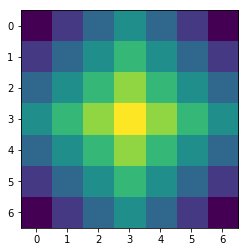

In [11]:
def boat_prior(boat_length, field_size):
    """
    Computes the prior probability to get a hit given the boat length and the size of the board.
    For a single-boat setup only.
    :param boat_length: Length of the boat, type: int
    :param field_size: size of the board, type: int
    
    :returns: np.ndarray of size (field_size, field_size) containing the probability of a hit for every field.
    """
    tmp_field = np.zeros((field_size, field_size))
    
    # Vertical boat position (all columns are the same)
    for i in range(field_size-boat_length+1):
            tmp_field[i:i+boat_length, :] += 1
            
    # Horizontal boat position are the same tabel just transposed
    tmp_field += tmp_field.T
    
    # Normalize table
    normalization_constant = boat_length/(2 * (field_size-boat_length+1) * field_size * boat_length)
    
    return normalization_constant * tmp_field

L_carrier = 4
carrier_prior = boat_prior(L_carrier, field_size = 7)
plt.imshow(carrier_prior)

In [12]:
# Sanity check: carrier_prior should sum to the length of the boat
carrier_prior.sum()

3.9999999999999996

### **2.2** Updating to a posterior given hit/miss observations

Let us define an `observation_board` that contains the observations. We use the following notation:  
    `0` unseen field  
    `-1` miss (water)  
    `1` hit  

**Task 1:** Write a function that takes as input the `observation_board` as well as the length of one boat, and that returns an array that contains the probability to get a hit at every coordinate of the field.

*Hint:* Again, this can be achieved by enumeration. Take care of all the constraints imposed by the `observation_board`!

In [18]:
def posterior_one_ship(observation_board, boat_length):
    """
    Computes the posterior probability to get a hit given an array of observed hits and misses as well as the boat length.
    For a single-boat setup only.
    :param observation_board: the board containing unobserved locations (0), misses (-1), and hits (1), type: np.ndarray
    :param boat_length: Length of the boat, type: int
    
    :returns: np.ndarray of the same size as the observation board containing the probability of a hit 
              for every field given the observations
    """
    
    tmp_posterior = np.zeros((field_size, field_size))
    
    n_hits = np.count_nonzero(observation_board == 1)
    print('n_hits', n_hits)
    # Vertical boat position (all columns are the same)
    for i in range(field_size):
        for j in range(field_size):
            
            # Check if vertical ship fits
            if i  < field_size-boat_length+1:
                tmp_ship1 = observation_board[i:i+boat_length, j]
                # we only consider possible ship locations that contain all hits and no misses
                if (n_hits == np.count_nonzero(tmp_ship1 == 1)) and not (-1 in tmp_ship1):
                    tmp_posterior[i:i+boat_length, j] += 1
            # Check if horizontal ship fits
            if j  < field_size-boat_length+1:
                tmp_ship2 = observation_board[i, j:j+boat_length]
                # we only consider possible ship locations that contain all hits and no misses
                if (n_hits == np.count_nonzero(tmp_ship2 == 1)) and not (-1 in tmp_ship2):
                    tmp_posterior[i, j:j+boat_length] += 1
    
    # Remove already scored hits
    tmp_posterior[observation_board == 1] = 0
    
    # Compute normalization constant
    normalization_sum = np.sum(tmp_posterior)/boat_length
    
    if normalization_sum != 0:
        tmp_posterior = (1/normalization_sum)*tmp_posterior
    else:
        raise ValueError('All entries in the posterior table have zero probability. Check the observation_board for invalid entries.')
    return tmp_posterior

**Task 2:** Test your function on the following `observation_board`s (just run the cells)

In [19]:
# board 1: Only misses
obs_board_1 = np.zeros((field_size, field_size)); obs_board_1[[1, 2, 5, 8], [8, 3, 4, 6]] = -1

# board 2: a few misses, one hit
obs_board_2 = np.copy(obs_board_1); obs_board_2[7, 1] = 1

# board 3: a few misses, two hits
obs_board_3 = np.copy(obs_board_2); obs_board_3[6, 1] = 1

# board 4: two for one boat impossible hits: This should cause an error
obs_board_4 = np.copy(obs_board_2); obs_board_4[6, 2] = 1

n_hits 0
Sum of posterior values:  4.999999999999999
n_hits 1
n_hits 2
n_hits 2


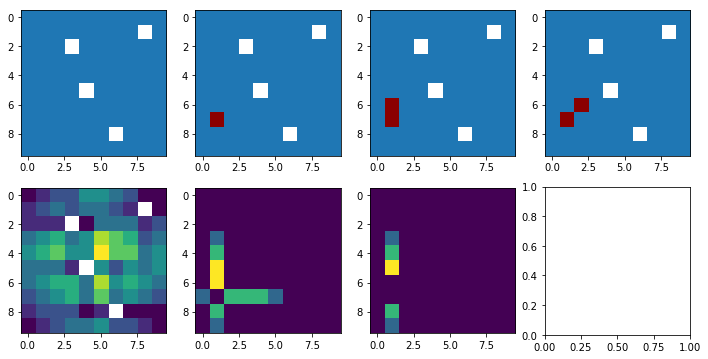

In [20]:
### VISUALIZATION
from matplotlib import colors

# making a custom discrete colormap for hits and misses
cmap_discrete = colors.ListedColormap(['white', 'C0','darkred'])
boundaries = [-1.5, -0.5, 0.5, 1.5]
norm = colors.BoundaryNorm(boundaries, cmap_discrete.N, clip=True)

# Plot the boards and the corresponding posterior
f, axs = plt.subplots(2, 4, figsize=(12,6))

cmap = matplotlib.cm.viridis  # Can be any colormap that you want after the cm
cmap.set_bad(color='w')

# board 1
post_1 = posterior_one_ship(obs_board_1, 5)
print('Sum of posterior values: ', np.sum(post_1))
axs[0, 0].imshow(obs_board_1, cmap=cmap_discrete, norm=norm)
axs[1, 0].imshow(np.ma.masked_where(post_1 == 0, post_1), cmap=cmap)

# board 2
axs[0, 1].imshow(obs_board_2, cmap=cmap_discrete, norm=norm)
axs[1, 1].imshow(posterior_one_ship(obs_board_2, 5))

# board 3
axs[0, 2].imshow(obs_board_3, cmap=cmap_discrete, norm=norm)
axs[1, 2].imshow(posterior_one_ship(obs_board_3, 5))

# board 4
axs[0, 3].imshow(obs_board_4, cmap=cmap_discrete, norm=norm)
try:
    axs[1, 3].imshow(posterior_one_ship(obs_board_4, 5))
except:
    pass

In [21]:
# board 4 should raise an error
posterior_one_ship(obs_board_4, 5)

n_hits 2


ValueError: All entries in the posterior table have zero probability. Check the observation_board for invalid entries.

### **2.3** Towards battleship with more than one boat
_Note: No coding required!_

Next week's assignment will deal with the full game of Battleships, which, according to the above rules, contains seven ships.

1. Think about how you would need to modify your above routines to compute  
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   (a) the prior over ship locations   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   (b) the posterior over ship locations given hit/miss observations  
    by enumerating all states. Describe the changes you would need to make to your code.
2. Why will it be hard to compute the posterior with multiple boats?

#### Answers
1.1 

(a) In the above inplementation I basically use brute force to loop over all possible placements of the ships. With $N$ being the length of the quadratic game board and $n$ the size of the current boat, looping over all possible placement options of **one ship** requires worst case roundabout $(2N(N-n+1))$ iterations. However, after placing the first ship I will need to loop over possible placements of the second ship, where I will need to loop over possible palcements of the third ship, and so on. This procedure gets computationally quite costly rather quickly.

(b) In my implementation for the posterior case, I would have the same problems looping over all possible positions of the boats with the addition of if statements in a lot of  nested for loops.

2. The number of possible boat placements is huge.



#### 1. Exam-Type Question
The likelihood for the $N$ binary i.i.d. observations $X:=[x_1,...,x_N]$ is
\begin{equation}
p(X|f) = \prod_{i=1}^{N} p(x_i|f) = f^{C} (1-f)^{N-C},
\end{equation}
with $C = \sum_{i=1}^N x_i$.

The posterior distribtuion of $p(f|x)$ is obtained via Bayes' Law as
\begin{align}
p(f|X) &= \frac{p(X|f)p(f|a,b)}{p(X)} \\
&= C_0 f^{C} (1-f)^{N-C} f^{a-1} (1-f)^{b-1}, \\
&= C_0  f^{C+a-1}(1-f)^{N-C+b-1},
\end{align}
with $C_0 = B(a,b) p(X)= B(C+a, N-C+b)$ being the normalization constant. Note that here the posterior takes the same form as the prior being a Beta distirbution. In other words, the Beta distribution is a conjugate prior to the Bernoulli distribution.

#### 2. Theory Question

(a)

With $Z = \frac{X}{X+Y}$ and $\bar{Z}=X+Y$. Solving for X and Y yields $Z = \frac{X}{\bar{Z}}$ and hence $X = Z\bar{Z}$ as well as $Y=\bar{Z}(1-Z)$. With $X \sim \mathcal{G}(X|a,1)$ and $Y \sim \mathcal{G}(Y|b,1)$ the joint distribution $f(X,Y) = f(X)f(Y)$ (these distributions are independent) reads in terms of $Z$ and $\bar{Z}$
\begin{equation}
f(\bar{Z},Z) = \frac{\lambda^a}{\Gamma (a)} \cdot (\bar{Z}Z)^{a-1} \cdot e^{-\lambda \bar{Z}Z} \cdot \frac{\lambda^b}{\Gamma (b)} \cdot \big(\bar{Z}(1-Z)\big)^{b-1} \cdot e^{-\lambda \bar{Z}(1-Z)} \text{det}\Bigg(\begin{bmatrix} \frac{\partial X}{\partial \bar{Z}} & \frac{\partial X}{\partial Z} \\ \frac{\partial Y}{\partial \bar{Z}} & \frac{\partial Y}{\partial Z} \end{bmatrix} \Bigg)
\end{equation}
with 
\begin{equation}
\text{det}\Bigg(\begin{bmatrix} \frac{\partial X}{\partial \bar{Z}} & \frac{\partial X}{\partial Z} \\ \frac{\partial Y}{\partial \bar{Z}} & \frac{\partial Y}{\partial Z} \end{bmatrix} \Bigg) = \bar{Z}.
\end{equation}

Note that if we rearrange the above equation, one term only is a function of $Z$ and denotes the beta distribution $Z \sim \text{Beta}(a,b)$.

(b)
\begin{align}
    E(X) &= \int^{1}_{0} x f_B(x) dx \\
         &= \frac{1}{B(a,b)}\int^{1}_{0} x^{a} (1-x)^{b-1} f_B(x) dx \\
         &= \frac{B(a+1,b)}{B(a,b)} \\
         &= \frac{\Gamma(a+1)\Gamma(b)}{\Gamma(a+b+1)} \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)} \\
         &= \frac{a}{a+b}\frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)} \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)} \\
         &= \frac{a}{a+b}
\end{align}
